# [DeepSphere]: a spherical convolutional neural network
[DeepSphere]: https://github.com/SwissDataScienceCenter/DeepSphere

[Nathanaël Perraudin](https://perraudin.info), [Michaël Defferrard](http://deff.ch), Tomasz Kacprzak, Raphael Sgier

# Demo: spherical harmonics vs graph Fourier modes

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from time import time

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import healpy as hp
import pygsp as pg
import itertools

from deepsphere import utils

In [3]:
plt.rcParams['figure.figsize'] = (17, 5)  # (9, 4) for matplotlib notebook

nside = 16
cm = plt.cm.RdBu_r
cm.set_under('w')

### ANAFAST: what is it?
Execution of anafast requires a user to specify the maximum spherical harmonic order  $\ell_{\mathrm{max}}$ up to which the harmonic decomposition of the input maps will be performed. Since there are no formal limits on parameter  $\ell_{\mathrm{max}}$ enforced by anafast, the user should make his/her choices judiciously. Hereafter it is convenient to specify  $\ell_{\mathrm{max}}$ in terms of the HEALPix map resolution parameter Nside (called nsmax in some other contexts). 

If the function to be analysed is strictly band-width limited, or nearly band-width limited (as in the case of a Gaussian beam smoothed signal discretized at a rate of a few pixels per beam area), it is sufficient to run anafast with  $\ell_{\mathrm{max}}\approx 2\cdot N_{\mathrm{side}}$, with a very good $C_\ell$ error performance already in the raw (i.e. uncorrected quadrature) harmonic transform mode. If quadrature corrections are still desired in this case, it should be sufficient to use, at no extra cost in execution time, the ring-weighted quadrature scheme. This is the recommended mode of operation of anafast for essentially error and worry free typical applications, e.g. CPU-intensive Monte Carlo studies. 

A new set of pixel-based quadrature weights was introduced in HEALPix 3.40. Pre-computed to inforce a (near) ideal integration of the spherical harmonics $Y_{\ell m}$ on the pixelized sphere (ie  $\frac{4\pi}{N_{\mathrm{pix}}} \sum_p w(p) Y_{\ell m}(p) = \sqrt{4 \pi} \delta_{\ell 0}\delta_{m 0}$) for  $\vert m\vert \le \ell \le 3 N_{\mathrm{side}}$, they can be used to insure that the $a_{\ell m}$ and $C_\ell$ computed by anafast are perfectly accurate (almost to machine precision) without the need for iterations, but only for band-width limited input signal with  $\ell_{\mathrm{max}}\le 1.5 N_{\mathrm{side}}$. 

If more aggressive attempts are undertaken to extract from a map the spectral coefficients at  $\ell > 2\cdot N_{\mathrm{side}}$ (for example, as in a possible case of an attempt to analyse an existing map, which was irreversibly binned at a suboptimal resolution) the following should be kept in mind: 

$\bullet$ __Spherical harmonics discretized using HEALPix (either sampled at pixel centers, or avaraged over pixel areas) form a linearly independent system up to  $\ell_{\mathrm{max}}= 3 \cdot N_{\mathrm{side}}-1$. Hence, the functions which are strictly band-width limited to  $\ell_{\mathrm{max}}= 3 \cdot N_{\mathrm{side}}-1$ can be fully spectrally resolved with anafast, albeit with integration errors in the uncorrected quadrature mode__, which grow up to  $\delta C_\ell \propto \epsilon \cdot C_\ell$, with $\epsilon <0.1$, at the highest values of $\ell$. These integration errors can be efficiently reduced using anafast in the iterative mode. Although this  $\ell_{\mathrm{max}}$ range --  $2 \cdot N_{\mathrm{side}}< \ell_{\mathrm{max}}< 3 \cdot N_{\mathrm{side}}- 1$ -- is easily manageable with anafast used on strictly band-width limited functions, it should be used with caution in basic and automated applications, e.g. Monte Carlo simulations. 

$\bullet$ __As with any discrete Fourier transform, anafast application to functions which are not band-width limited results with aliasing of power, which can not be remedied__. If the particular case of interest may result in such a band-width violation (i.e. there is significant power in the function at  $\ell > 3 \cdot N_{\mathrm{side}}-1$), the function should be smoothed before the application of anafast, or discretized and then analysed, on a refined HEALPix grid (with larger Nside). 

$\bullet$ REMEMBER: A peculiar property of the sphere, which usually surprises those whose intuition is built on experience with FFTs on a segment, or on a Euclidean
multidimensional domain, is the lack of a regular and uniform point-set at arbitrary resolution, and the resulting __non-commutativity of the forward and backward discrete Fourier transforms__ on nearly-uniform point-sets, e.g. HEALPix. Hence, as in any case of attempting an extreme application of an off-the-shelf software, use caution and understand your problem well before executing anafast under such circumstances!


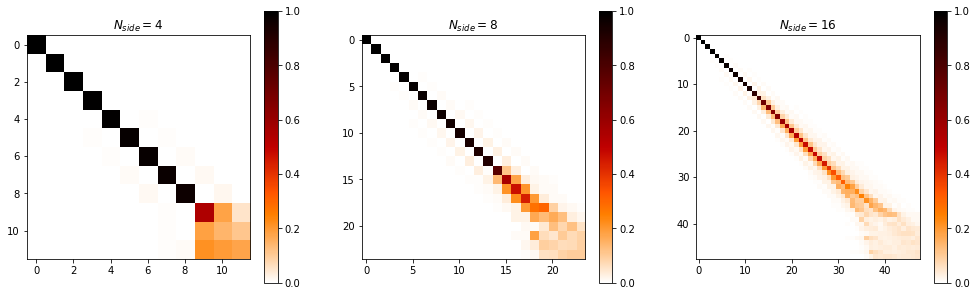

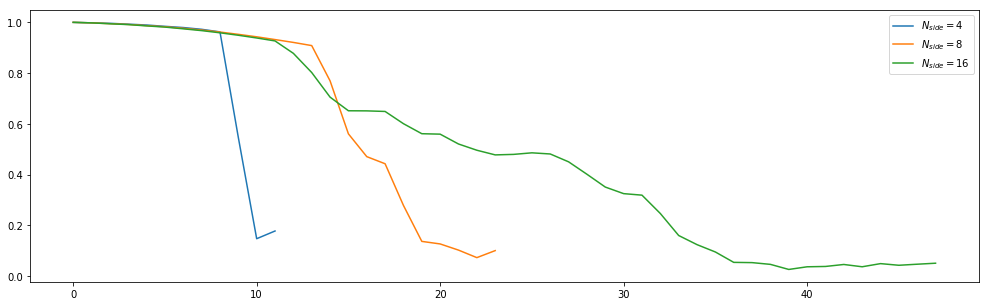

In [10]:
# nsides = [4, 8, 16, 32]  # slow
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1  # default in healpy.anafast

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graph = utils.healpix_graph(nside, lap_type='normalized', nest=True, dtype=np.float64, std_dev='kernel_width')
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$N_{{side}}={nside}$')

ax2.legend();

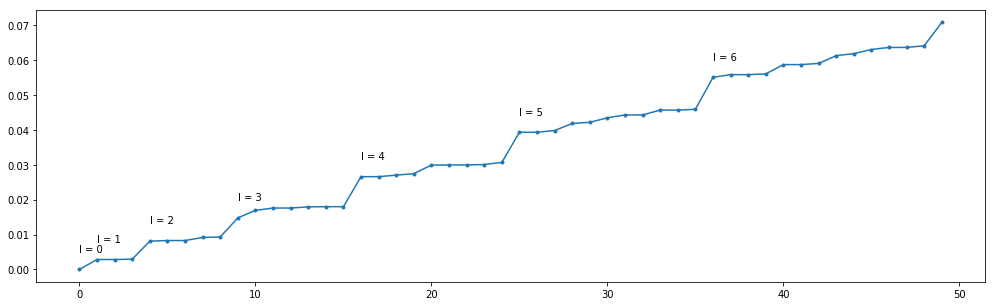

In [11]:
plt.plot(graph.e[:50], '.-')
idx = 0
for l in range(7):
    plt.text(idx, graph.e[idx] + 0.005, 'l = {}'.format(l))
    idx += 2*l + 1

### 4.5 Testing convergence of Belkin & Nyiogi setting
More or less: here the sampling is deterministic (HEALPix) but we construct a full graph

I added two functions to deepsphere.utils: __full_healpix_graph__ and __full_healpix_weightmatrix__.
__full_healpix_weightmatrix__() uses as standard deviation of the gaussin kernel exactly the formula used in Belkin&Nyiogi, and NOT the mean of the distances.

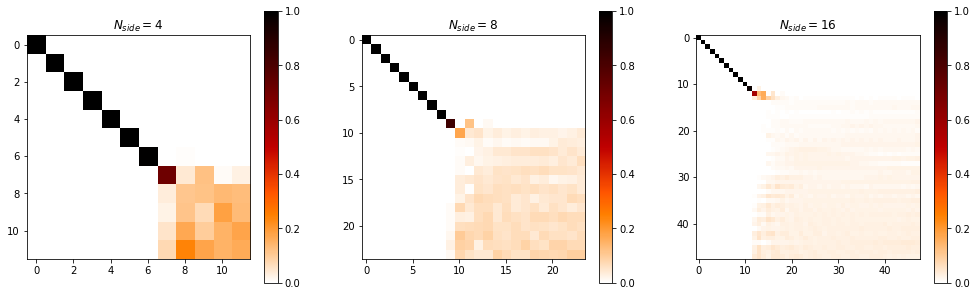

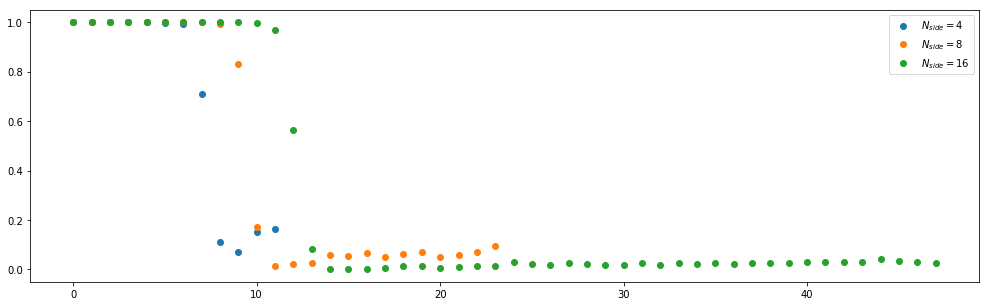

In [20]:
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graph = utils.full_healpix_graph(nside, dtype=np.float64, std='BelkinNyiogi')  # in NEST order
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();

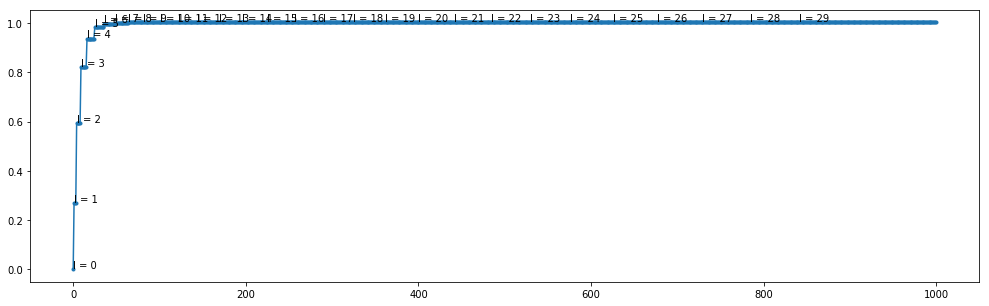

In [21]:
plt.plot(graph.e[:1000], '.-')
idx = 0
for l in range(30):
    plt.text(idx, graph.e[idx] + 0.005, 'l = {}'.format(l))
    idx += 2*l + 1

Nath's thought: 

### 4.6 Now we try with a FULL graph with a standard deviation set to mean distance of the dataset
This is to see if the convergence is due to the standard deviation or to the density pattern (or both)

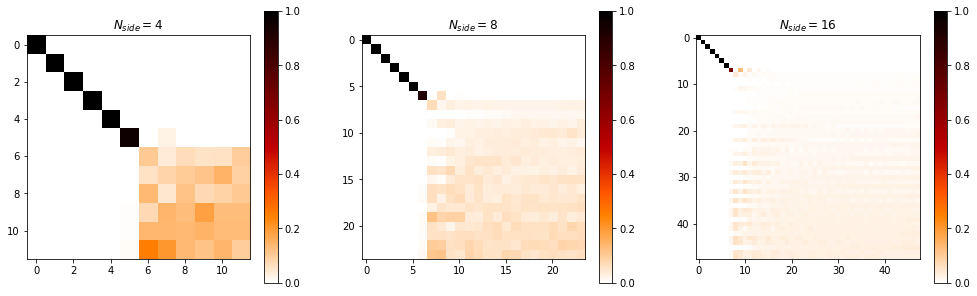

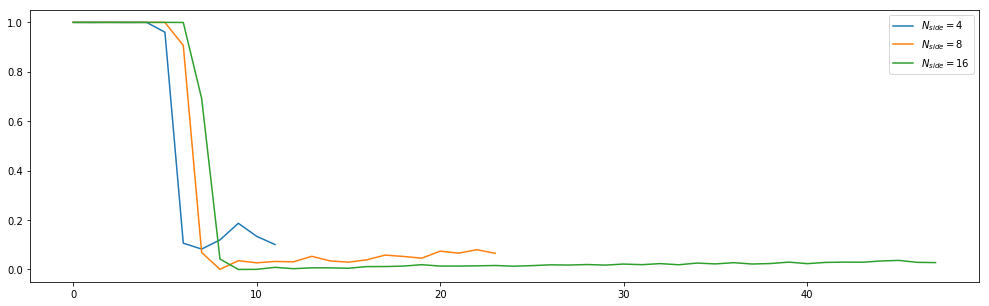

In [62]:
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graph = utils.full_healpix_graph(nside, dtype=np.float64, std="kernel_width")  # in NEST order
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$N_{{side}}={nside}$')

ax2.legend();

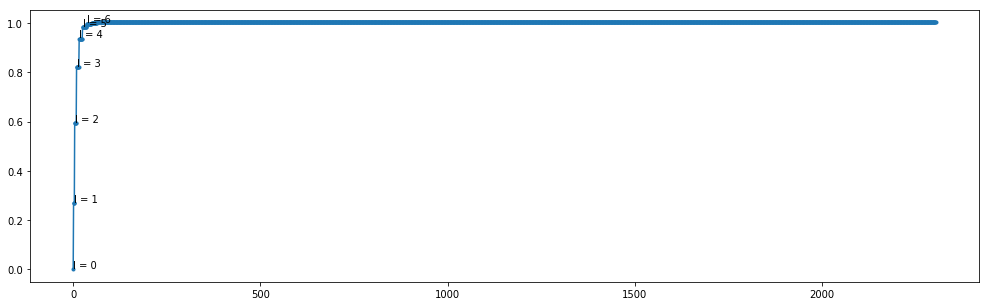

In [22]:
plt.plot(graph.e, '.-')
idx = 0
for l in range(7):
    plt.text(idx, graph.e[idx] + 0.005, 'l = {}'.format(l))
    idx += 2*l + 1

It seems that the convergence is still there, but now it is way slower! Now the question is: what is provoking this convergence? a Shannon theorem (perfect reconstruction up to a certain bandwidth) or is it just an asymptotic thing (Belking/Nyiogi style)? The superfast decay of the plot indicating the energy on the diagonal indicate that the graph fourier eigenvectors approximate the real sphericl harmonics almost exactly for a while, and then boom something wrong happens.

Now that we saw that the std dev is really important, let's see what happens to the sparse graph (7/8 neighbors) and the Belkin & Nyiogi std. dev.!

### 4.7 Sparse graph with Belkin-Nyiogi standard deviation

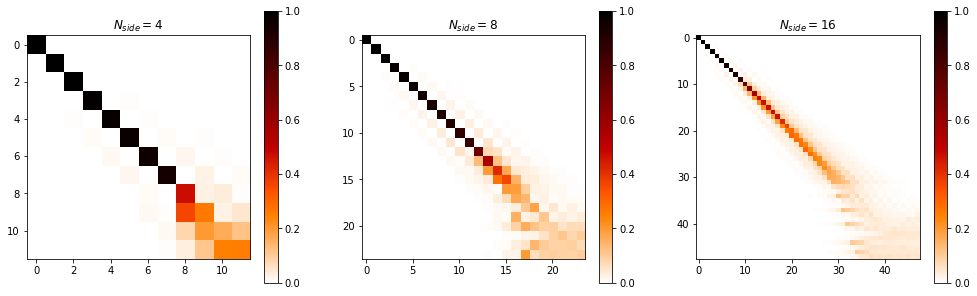

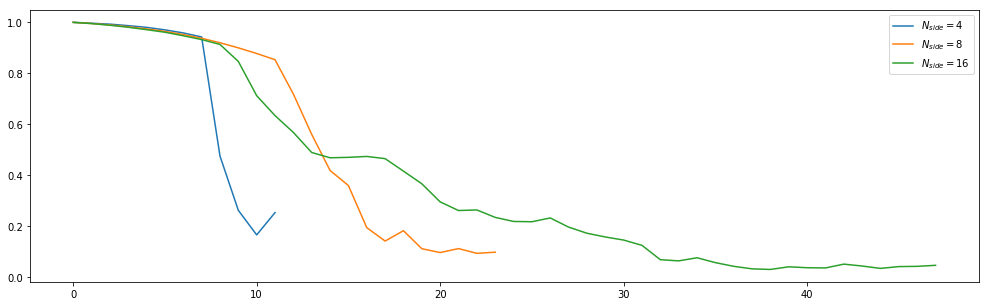

In [64]:
# nsides = [4, 8, 16, 32]  # slow
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graph = utils.healpix_graph(nside, lap_type='normalized', nest=True, dtype=np.float64, std_dev='BelkinNyiogi')
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$N_{{side}}={nside}$')

ax2.legend();

__In this case (sparse graph) the standard deviation does not seem to help at all!__

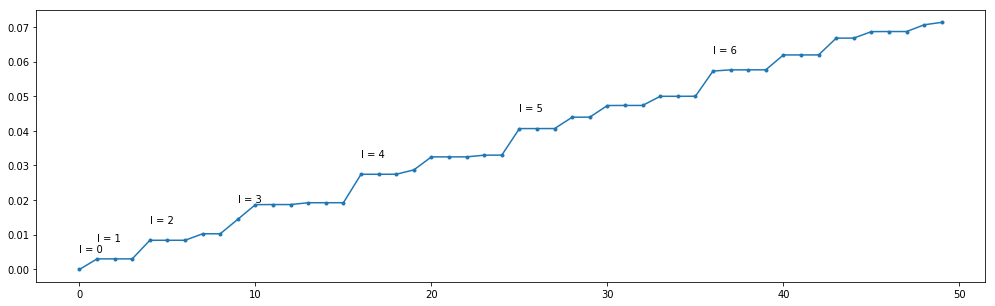

In [65]:
plt.plot(graph.e[:50], '.-')
idx = 0
for l in range(7):
    plt.text(idx, graph.e[idx] + 0.005, 'l = {}'.format(l))
    idx += 2*l + 1

### 4.7 Just for confirmation: SHT of the sampled spherical harmonics

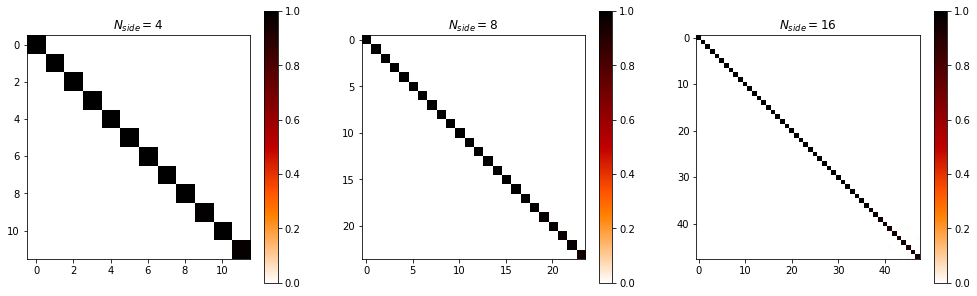

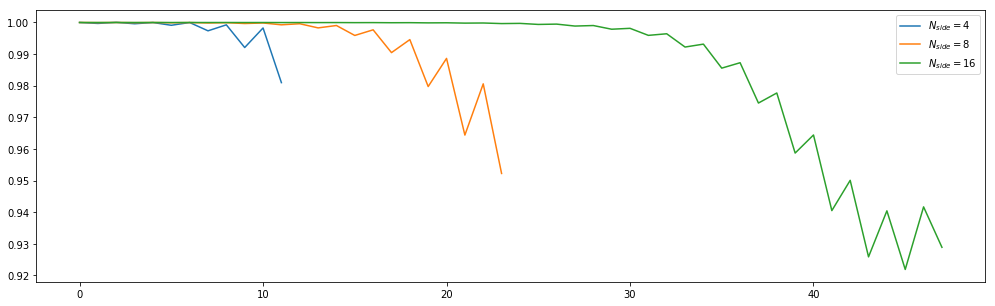

In [30]:
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1
    
    harmonics = utils.compute_spherical_harmonics(nside, lmax=lmax)
    n_harmonics = harmonics.shape[1]
    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        harmonic = hp.reorder(harmonics[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(harmonic, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, label=rf'$N_{{side}}={nside}$')

ax2.legend();


## 5 Analysis of the sparsity of the graph

We want to go deeper in the analysis of how the sparsity of the graph influences the convergence, since we observed that for a 7/8 neighbours graph we do not observe the convergence that we observe in the full graph. 

Hypothesis: if the standard deviation of the gaussian kernel is smaller than the smallest distance of the 7/8 neighbours, then we should be able to integrate it pretty well!
Drawback: maybe to integrate it we need a bit more points: how many? relate the radius needed for the radius graph and the standard deviation of the kernel!

### Recap: full graph with kernel_width standard deviation

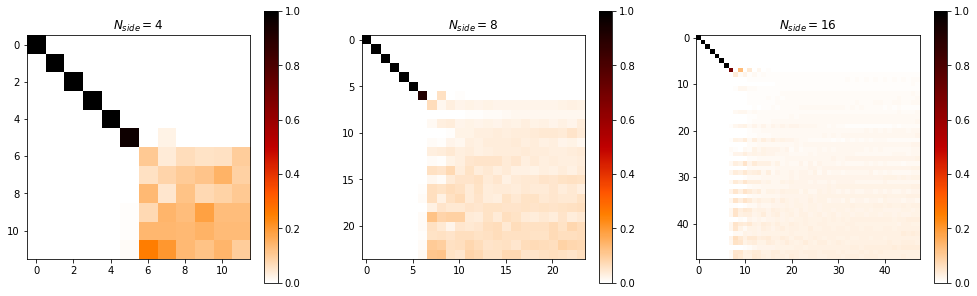

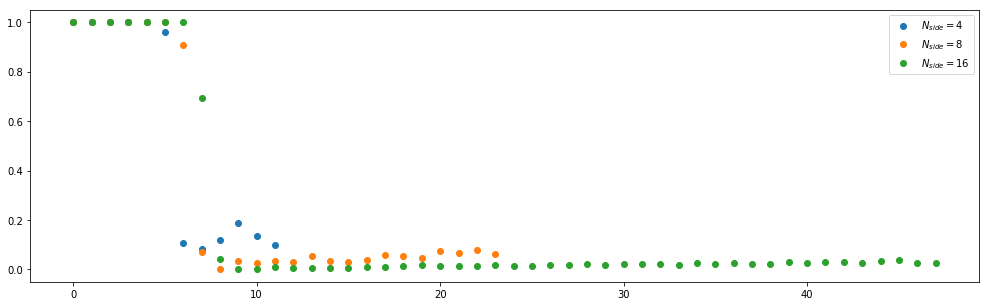

In [79]:
for nside in nsides:

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]

    graph = utils.full_healpix_graph(nside, dtype=np.float64, std="kernel_width")  # in NEST order
    # graph = utils.healpix_graph(nside, dtype=np.float64)  # in NEST order

    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

    fig1, axes = plt.subplots(1, len(nsides))
    fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();
plt.show()

### Playing with a very sparse graph

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


0.8
0.8


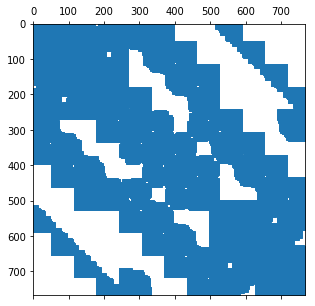

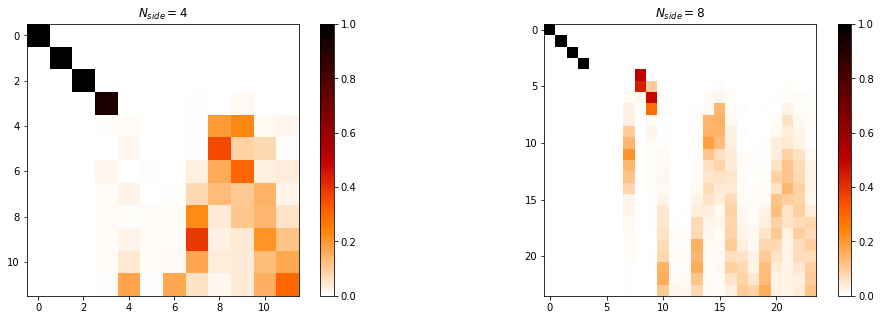

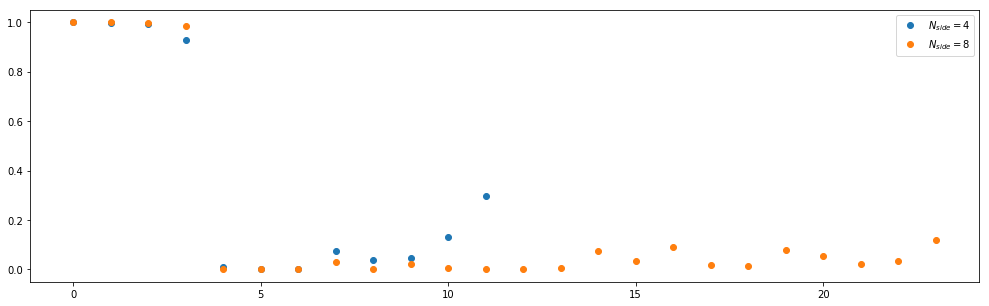

0.8500000000000001
0.8500000000000001


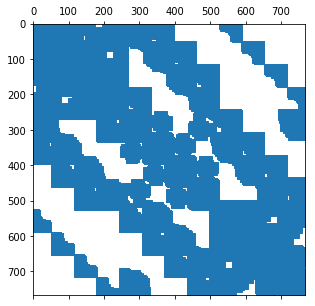

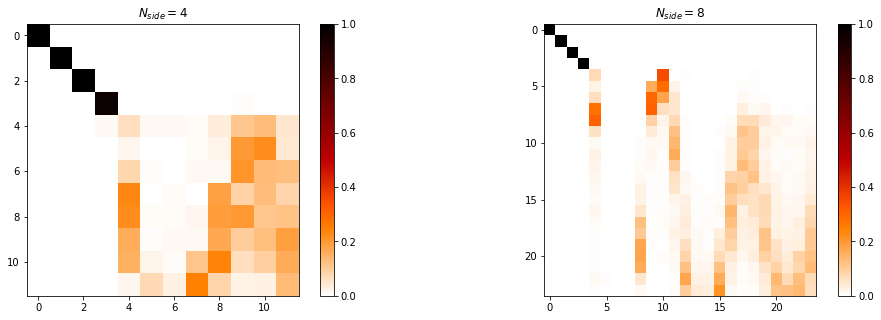

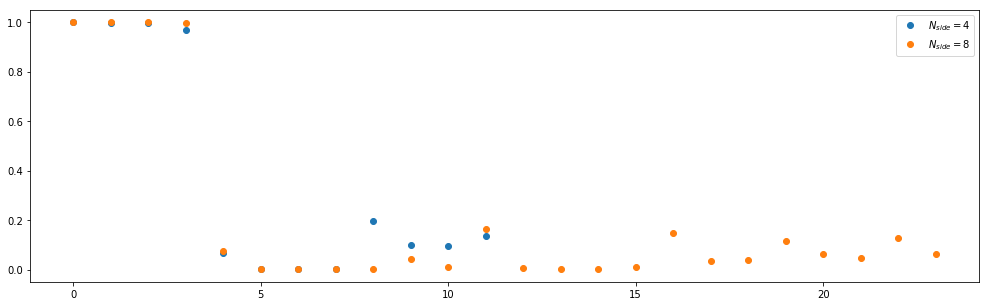

0.9
0.9


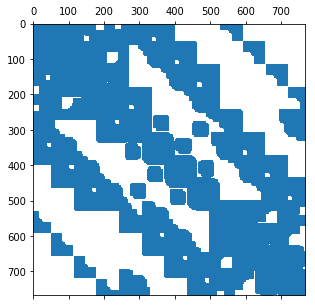

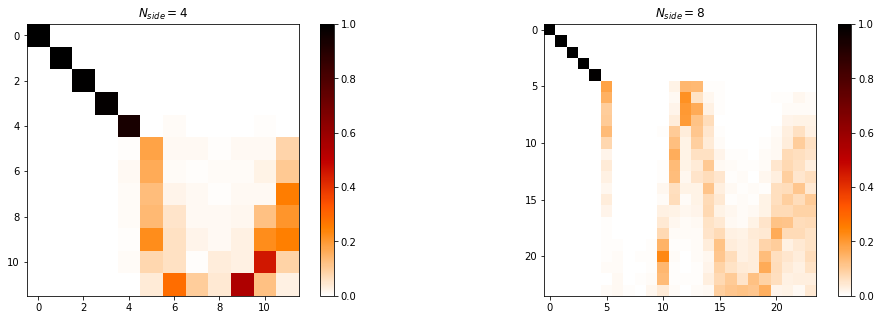

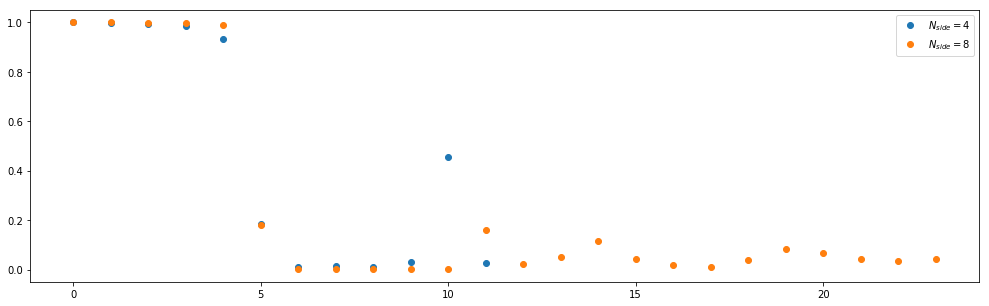

0.95
0.95


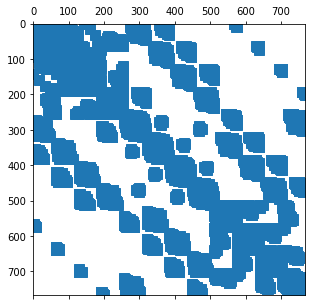

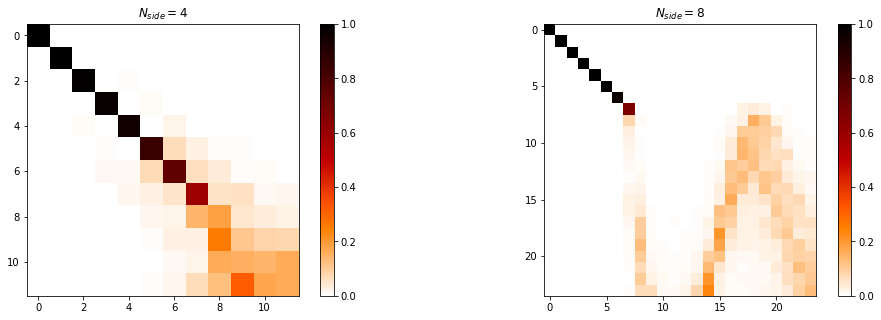

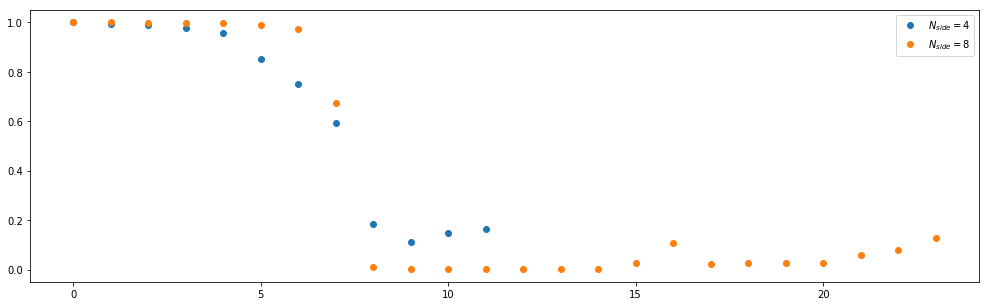

In [6]:
nsides = [4, 8]

spectral_content = dict()

K = 0.9252874820330129

ks=np.linspace(0.8, 1, 5)[:-1]
for k in ks:
    for nside in nsides:

        lmax = 3 * nside - 1

        n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
        
        graph = utils.full_healpix_graph(nside, dtype=np.float64, std="kernel_width")  # in NEST order
        # graph = utils.healpix_graph(nside, dtype=np.float64)  # in NEST order
        
        # thresholding weights to impose sparsity     
        W = graph.W.copy()
        W[W < k] = 0
        plt.spy(W)
        graph = pg.graphs.Graph(W)
        print(k)
        graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

        cl = np.empty((n_harmonics, lmax+1))
        for i in range(n_harmonics):
            eigenvector = hp.reorder(graph.U[:, i], n2r=True)
            # alm = hp.sphtfunc.map2alm(eigenvector)
            cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

        spectral_content[nside] = np.empty((lmax+1, lmax+1))
        start = 0
        for ell in range(lmax+1):
            end = start + (2 * ell + 1)
            spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
            start = end

    fig1, axes = plt.subplots(1, len(nsides))
    fig2, ax2 = plt.subplots()

    for ax, (nside, sc) in zip(axes, spectral_content.items()):
        sc = sc / sc[0, 0]
        im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
        fig1.colorbar(im, ax=ax)
        ax.set_title(rf'$N_{{side}}={nside}$')

        energy_in = np.diag(sc)
        ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

    ax2.legend();
    plt.show()

__Crazy stuff! the more I sparsify the graph the better it becomes! With a threshold of 0.95 it is actually better than the full graph!__

### 5.2 Playing with a not-so-sparse graph with Belkin&Nyiogi standard deviation

0.0
0.0


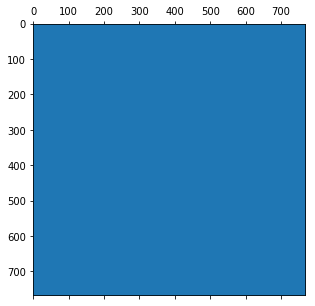

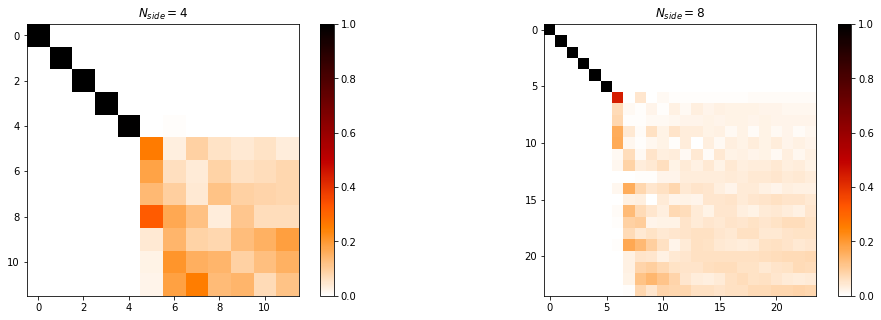

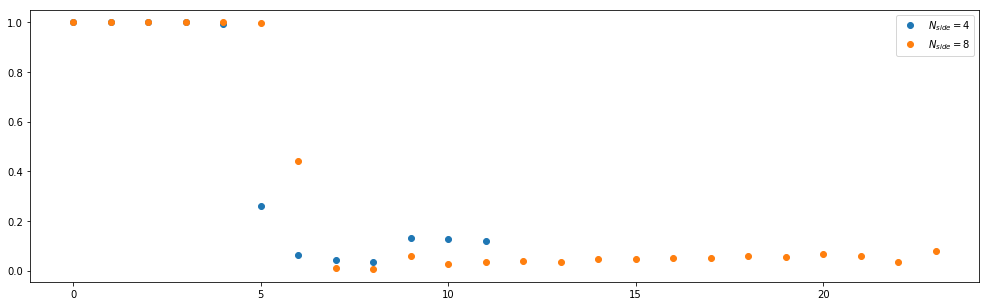

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


0.2
0.2


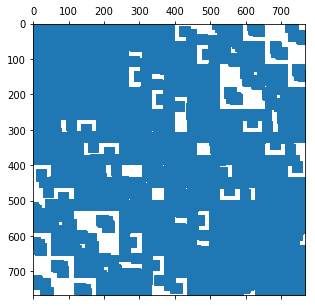

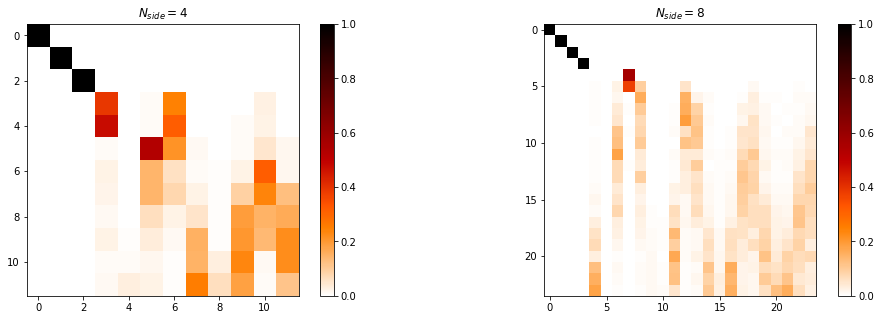

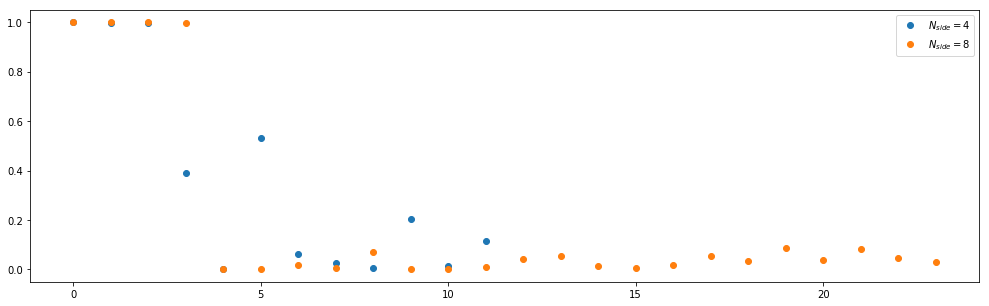

0.4
0.4


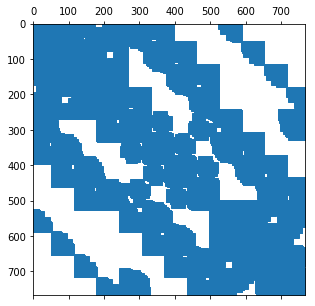

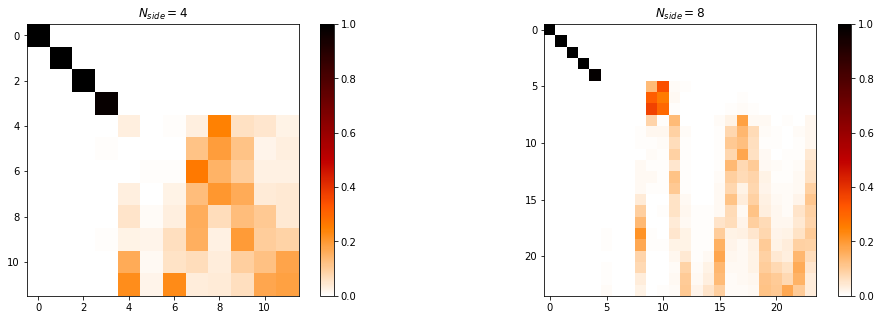

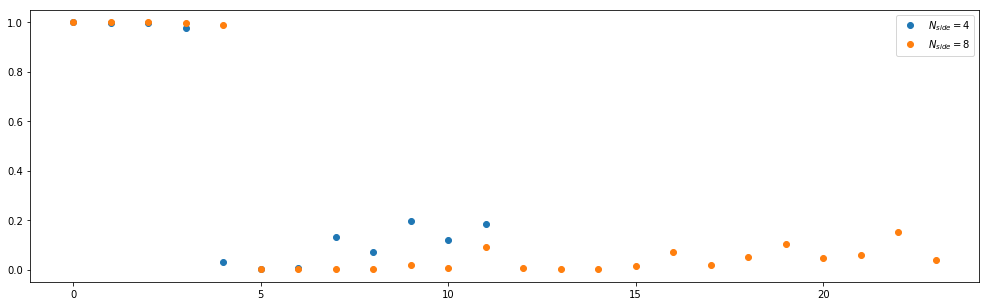

0.6000000000000001
0.6000000000000001


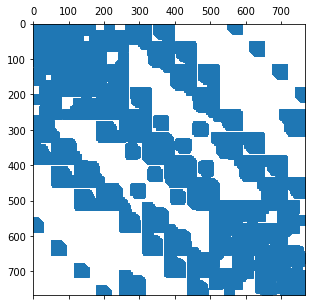

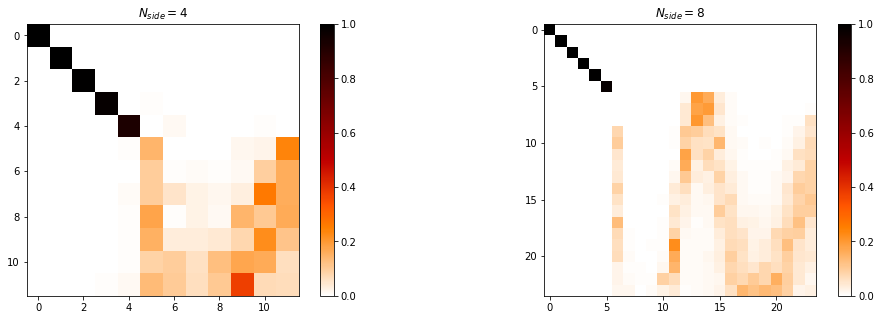

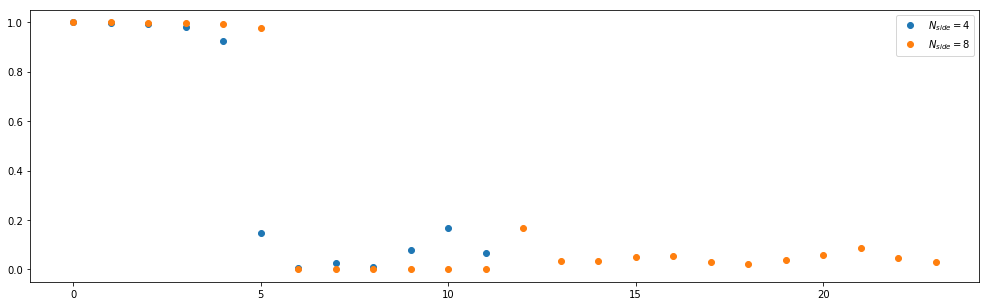

0.8
0.8


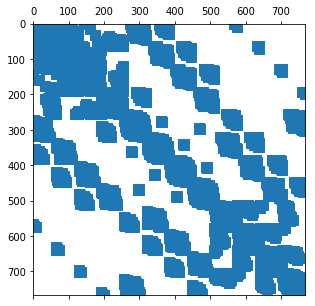

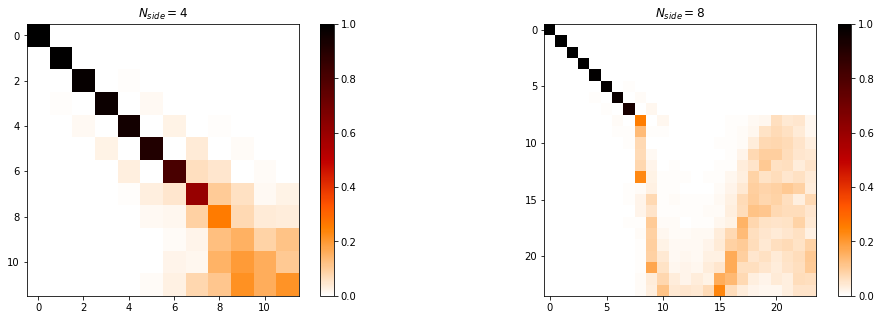

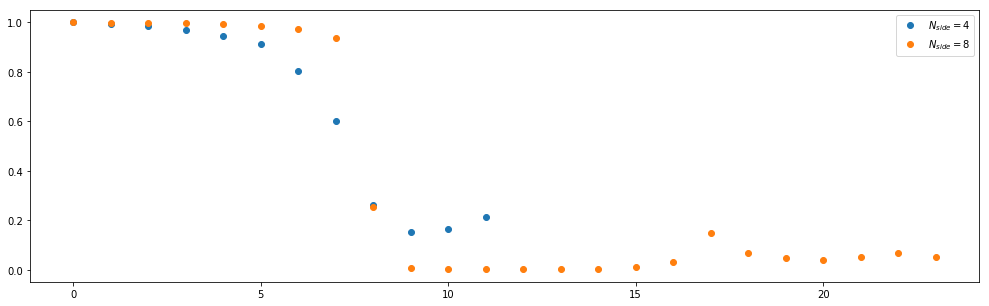

In [5]:
nsides = [4, 8]

spectral_content = dict()

K = 0.9252874820330129

ks=np.linspace(0, 0.8, 5)
for k in ks:
    for nside in nsides:

        lmax = 3 * nside - 1

        n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
        
        graph = utils.full_healpix_graph(nside, dtype=np.float64, std="BelkinNyiogi")  # in NEST order
        # graph = utils.healpix_graph(nside, dtype=np.float64)  # in NEST order
        
        # thresholding weights to impose sparsity     
        W = graph.W.copy()
        W[W < k] = 0
        plt.spy(W)
        graph = pg.graphs.Graph(W)
        print(k)
        graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

        cl = np.empty((n_harmonics, lmax+1))
        for i in range(n_harmonics):
            eigenvector = hp.reorder(graph.U[:, i], n2r=True)
            # alm = hp.sphtfunc.map2alm(eigenvector)
            cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

        spectral_content[nside] = np.empty((lmax+1, lmax+1))
        start = 0
        for ell in range(lmax+1):
            end = start + (2 * ell + 1)
            spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
            start = end

    fig1, axes = plt.subplots(1, len(nsides))
    fig2, ax2 = plt.subplots()

    for ax, (nside, sc) in zip(axes, spectral_content.items()):
        sc = sc / sc[0, 0]
        im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
        fig1.colorbar(im, ax=ax)
        ax.set_title(rf'$N_{{side}}={nside}$')

        energy_in = np.diag(sc)
        ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

    ax2.legend();
    plt.show()

__Crazy stuff! If it is just a bit sparse, the results are way worse than a full graph. However, the more I sparsify the graph the better it becomes, until it gets even "better" than the full graph! With a threshold of 0.95 it is actually "better" than the full graph!__

I need a finer analysis: let's concentrate only on Nside=8 and refine the analysis

### Fine analysis of the sparsity for a graph with $N_{side}=8$ and $t_n$ according to B&N

Threshold:  0.0
Number of neighbours:  767.0


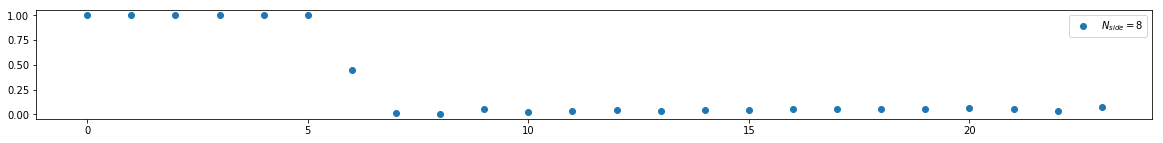

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Threshold:  0.05263157894736842
Number of neighbours:  430.6354166666667


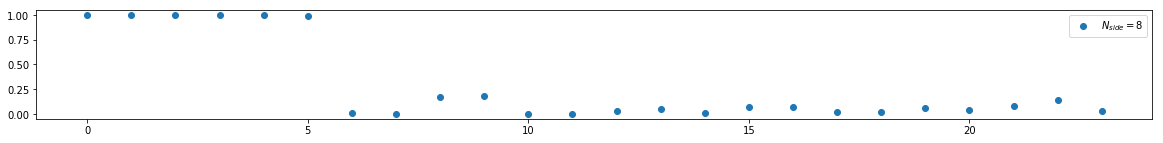

Threshold:  0.10526315789473684
Number of neighbours:  329.1145833333333


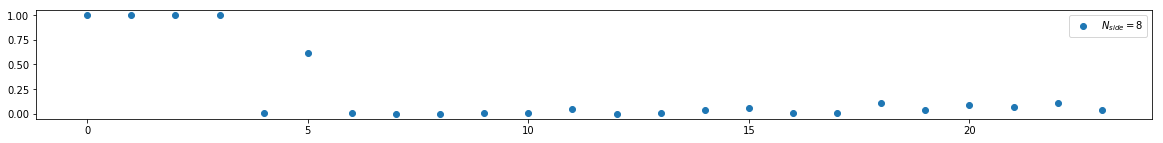

Threshold:  0.15789473684210525
Number of neighbours:  268.2604166666667


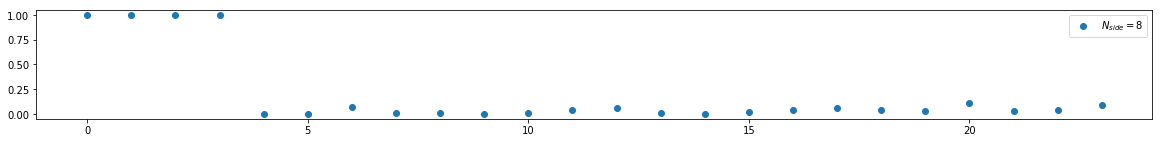

Threshold:  0.21052631578947367
Number of neighbours:  228.26041666666666


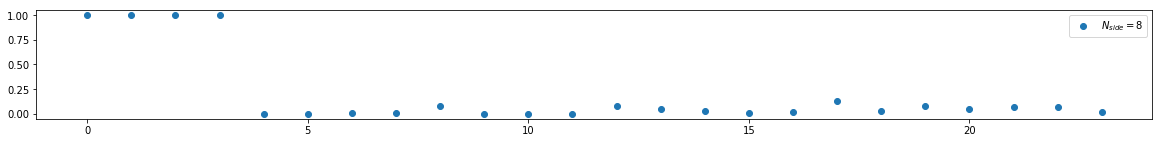

Threshold:  0.2631578947368421
Number of neighbours:  196.03125


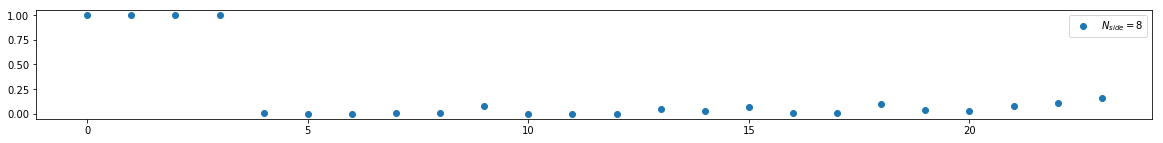

Threshold:  0.3157894736842105
Number of neighbours:  167.45833333333334


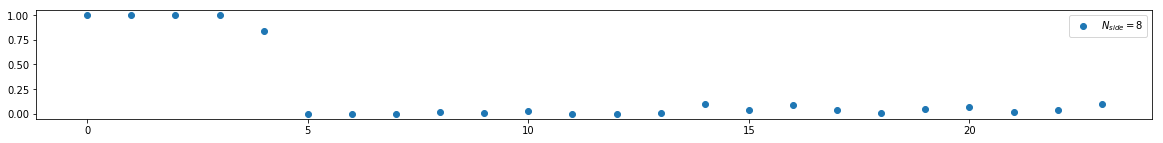

Threshold:  0.3684210526315789
Number of neighbours:  146.10416666666666


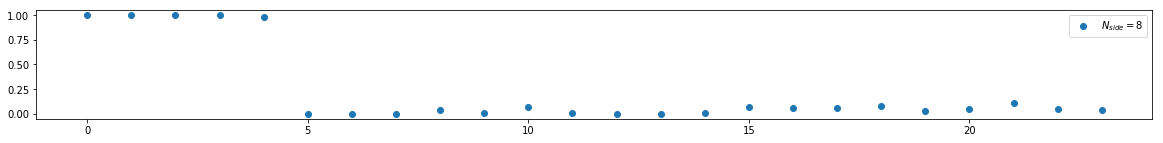

Threshold:  0.42105263157894735
Number of neighbours:  125.85416666666667


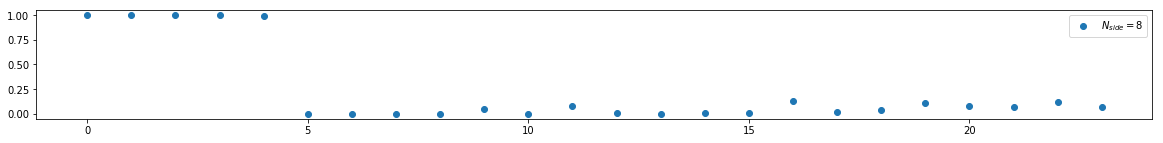

Threshold:  0.47368421052631576
Number of neighbours:  108.20833333333333


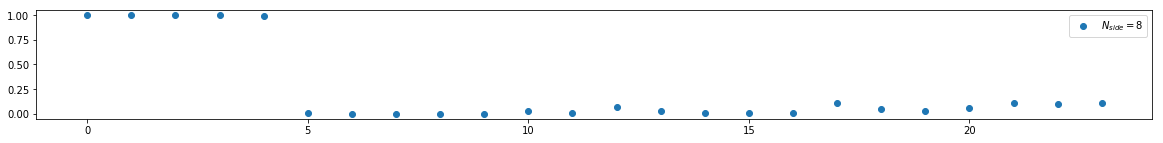

Threshold:  0.5263157894736842
Number of neighbours:  92.95833333333333


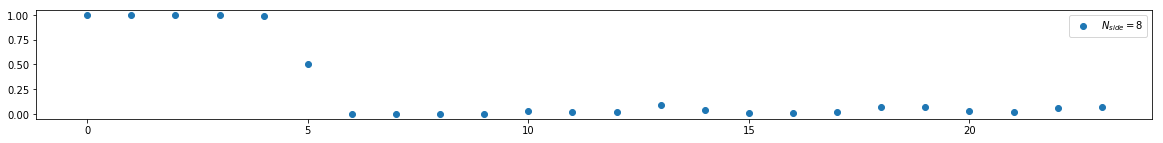

Threshold:  0.5789473684210527
Number of neighbours:  79.22916666666667


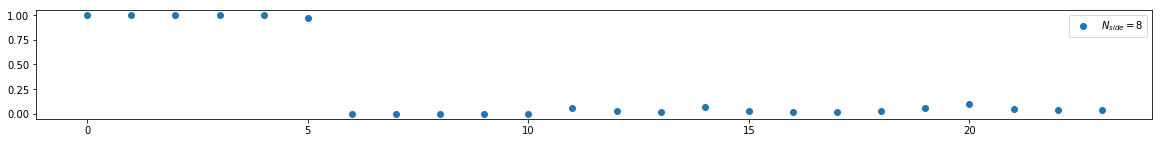

Threshold:  0.631578947368421
Number of neighbours:  65.90625


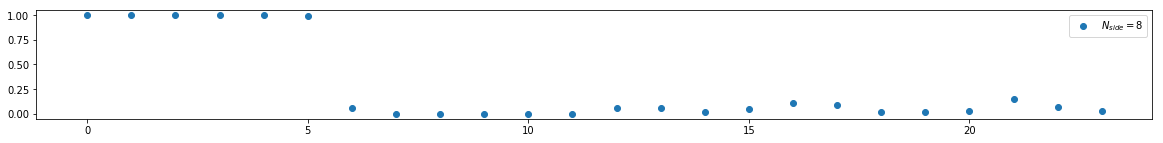

Threshold:  0.6842105263157894
Number of neighbours:  55.989583333333336


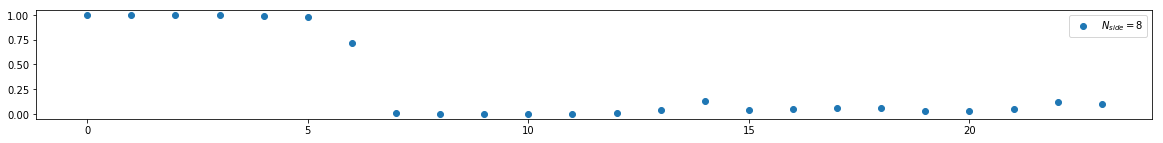

Threshold:  0.7368421052631579
Number of neighbours:  42.510416666666664


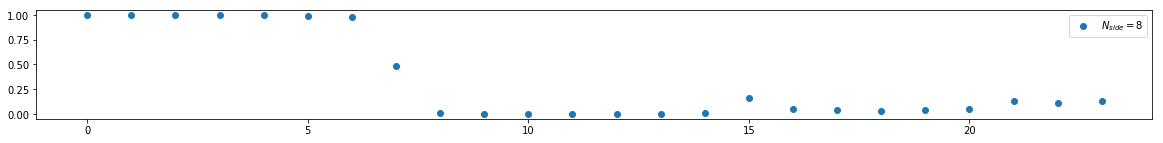

Threshold:  0.7894736842105263
Number of neighbours:  34.760416666666664


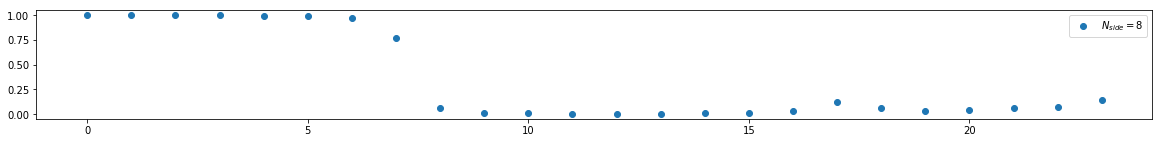

Threshold:  0.8421052631578947
Number of neighbours:  22.989583333333332


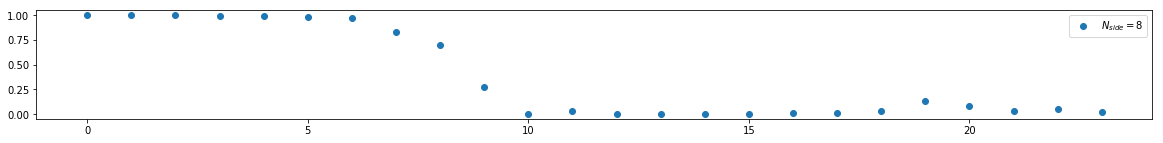

Threshold:  0.894736842105263
Number of neighbours:  15.802083333333334


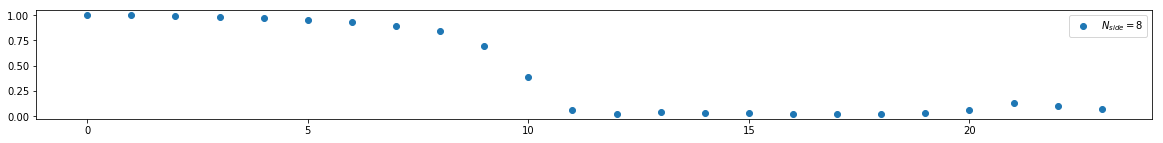

Threshold:  0.9473684210526315
Number of neighbours:  7.25


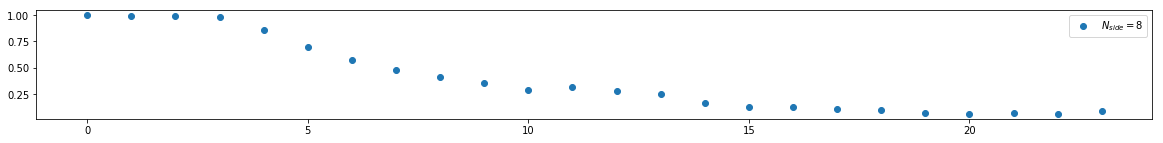

In [24]:
spectral_content = dict()

ks=np.linspace(0, 1, 20)[:-1]
for k in ks:
    nside = 8

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]

    graph = utils.full_healpix_graph(nside, dtype=np.float64, std="BelkinNyiogi")  # in NEST order
    # graph = utils.healpix_graph(nside, dtype=np.float64)  # in NEST order

    # thresholding weights to impose sparsity     
    W = graph.W.copy()
    W[W < k] = 0
    graph = pg.graphs.Graph(W)
    print("Threshold: ", k)
    print("Number of neighbours: ", np.mean(np.sum(W>0, axis=1)))
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

    fig2, ax2 = plt.subplots(figsize=(20,2))

    sc = spectral_content[nside]
    sc = sc / sc[0, 0]

    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

    ax2.legend();
    plt.show()

__Comments__: we see that we get worse results as we keep sparsifying up to 196 neighbors, but then it starts to get better and better until we hit 16 neighbors. Then, with only 7 neighbors, it gets worse.

Can you explain this behaviour? What is numerical and what is analythical? To answer this question, let's start looking a bit at understanding the function that we are trying to integrate: $$\int_{\mathcal S_2}e^{-\frac{||x-y||^2}{4t_n}}Y_l^m(y)d\mu_y$$


Maybe it could be explained by the fact that eliminating points that are far from $x$, the euclidean distance better approximate the geodesic distance and thus we are eliminating sources of errors! Let's try to see what happens with the geodesic distances!
### How is $t_n$ distributed?
This is to understand how large the kernel is for different values of $N_{side}$

Text(0,0.5,'$t_n$')

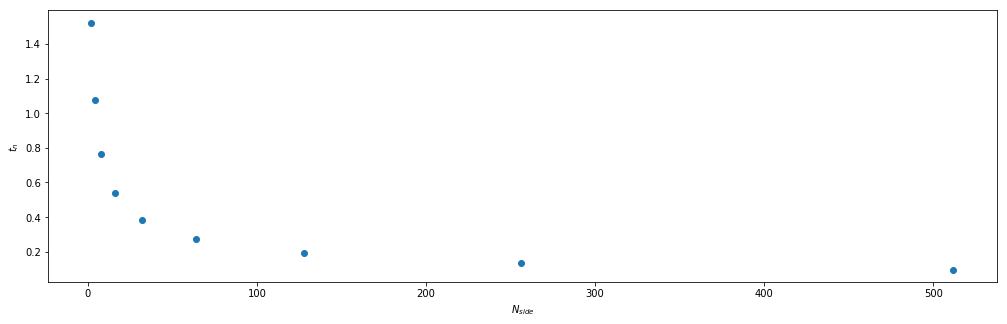

In [50]:
y = []
for i in range(1, 10):
    Nside = 2**i
    npix = 12*(Nside**2)
    y.append(utils.tn(npix))
plt.plot([2**i for i in range(1,10)], y, 'o')
plt.xlabel('$N_{side}$')
plt.ylabel('$t_n$')

$t_n$ is really big! For $N_{side}=8$, $t_n(8)=0.76$

In [5]:
Nside = 8
npix = 12*(Nside**2)
tn = utils.tn(npix)

In [7]:
np.exp(-(4*tn)**2/(4*tn))

0.04726629345947346

## 6  Full HEALPix graph with geodesic distances

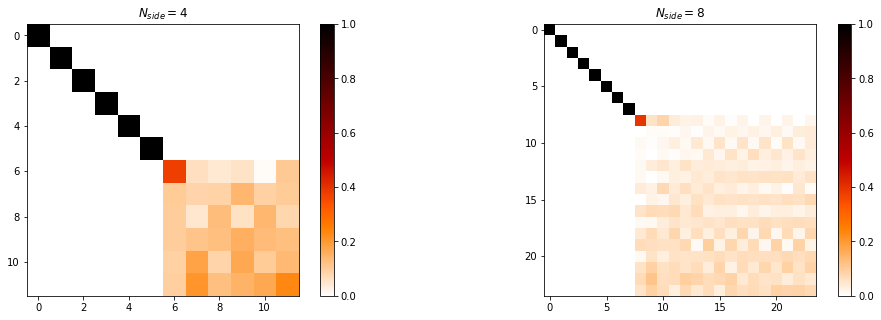

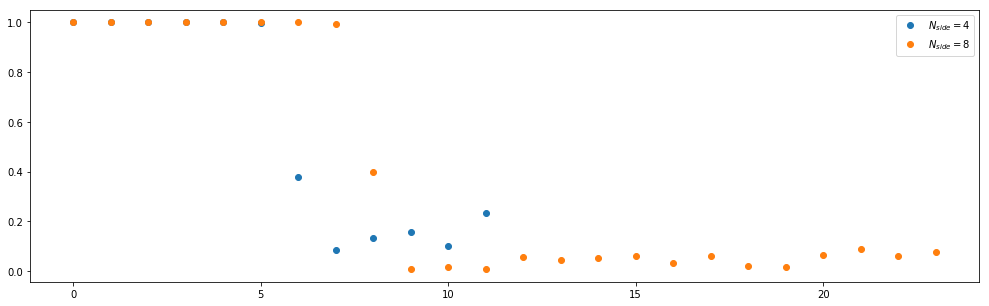

In [29]:
nsides = [4, 8]
spectral_content = dict()
for nside in nsides:

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]

    graph = utils.full_healpix_geodesic_graph(nside, dtype=np.float64, std="BelkinNyiogi")  # in NEST order
    # graph = utils.healpix_graph(nside, dtype=np.float64)  # in NEST order

    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();


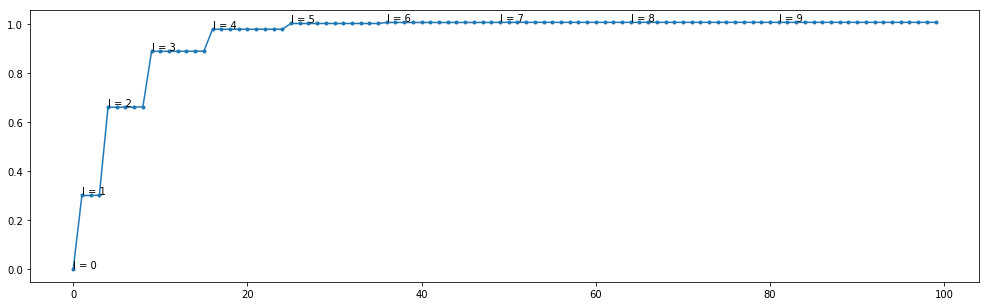

In [30]:
plt.plot(graph.e[:100], '.-')
idx = 0
for l in range(10):
    plt.text(idx, graph.e[idx] + 0.005, 'l = {}'.format(l))
    idx += 2*l + 1

__Comments__: the euclidean distance works better! Weird (?)

### Sparse analysis of geodesic graph

Threshold:  0.0
Number of neighbours:  767.0


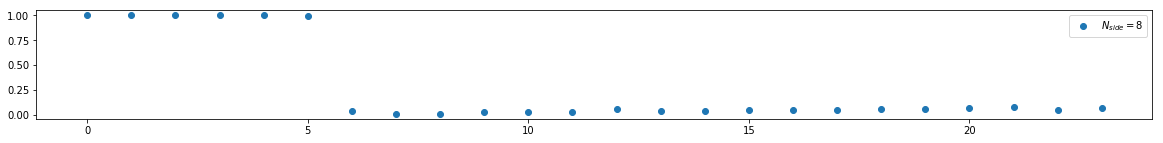

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Threshold:  0.05263157894736842
Number of neighbours:  356.0


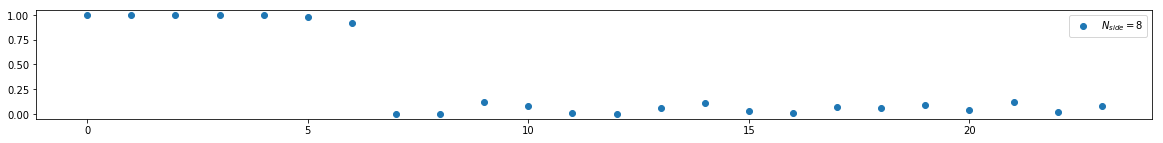

Threshold:  0.10526315789473684
Number of neighbours:  284.6770833333333


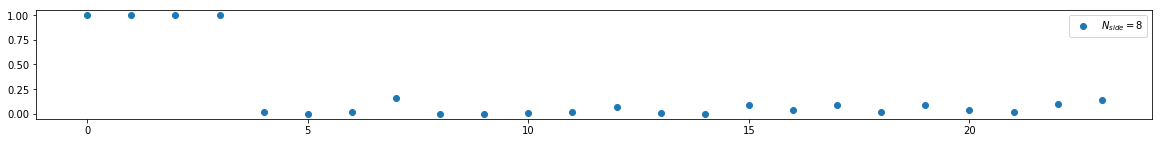

Threshold:  0.15789473684210525
Number of neighbours:  240.03125


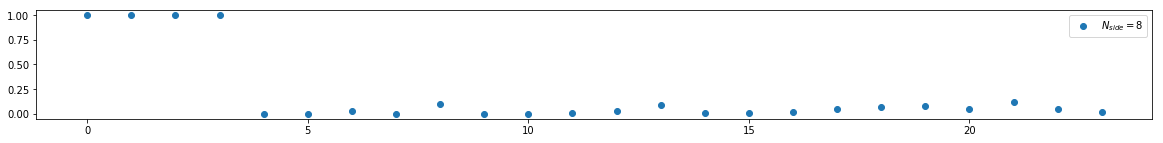

Threshold:  0.21052631578947367
Number of neighbours:  205.86458333333334


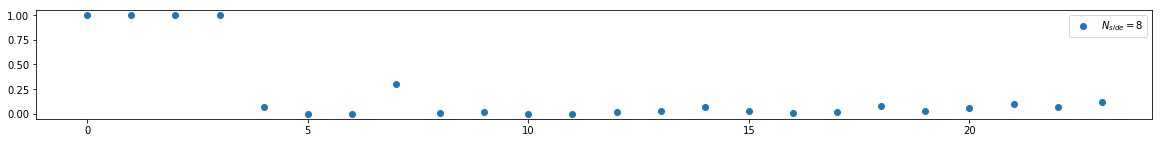

Threshold:  0.2631578947368421
Number of neighbours:  176.58333333333334


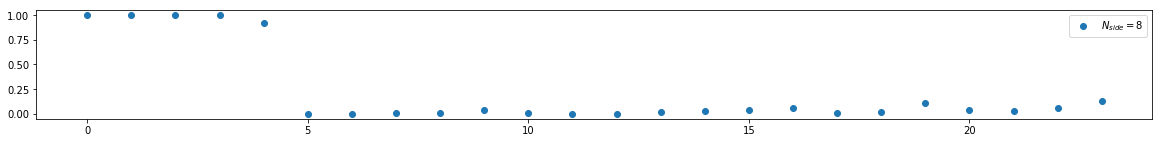

Threshold:  0.3157894736842105
Number of neighbours:  156.60416666666666


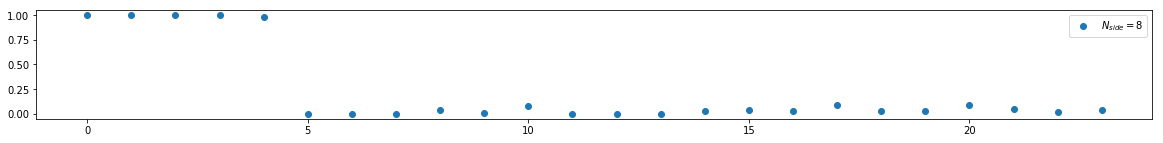

Threshold:  0.3684210526315789
Number of neighbours:  134.39583333333334


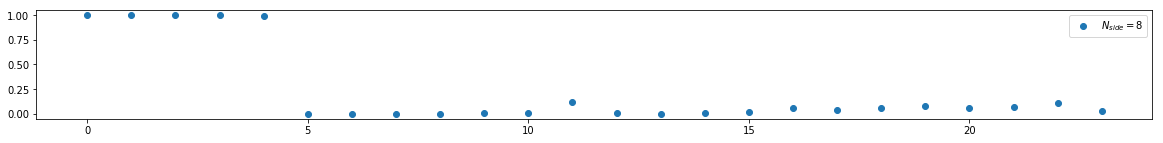

Threshold:  0.42105263157894735
Number of neighbours:  119.97916666666667


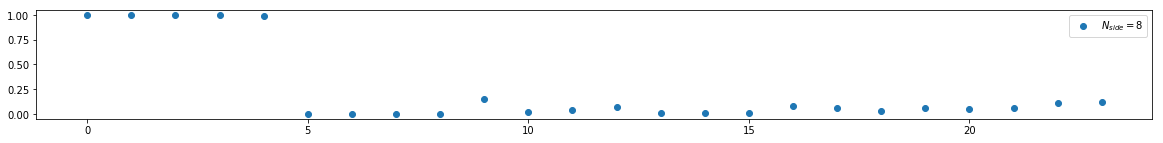

Threshold:  0.47368421052631576
Number of neighbours:  100.97916666666667


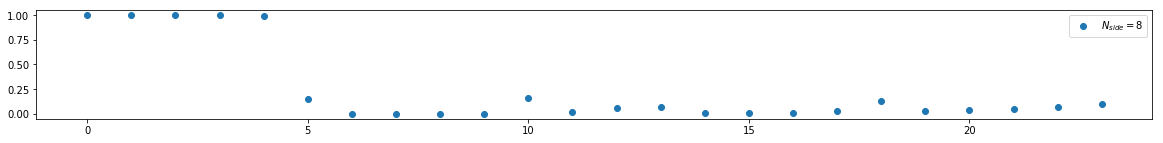

Threshold:  0.5263157894736842
Number of neighbours:  89.97916666666667


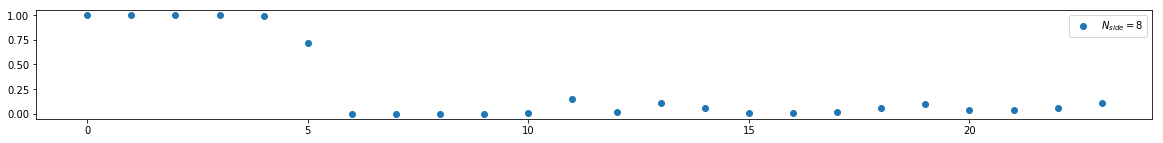

Threshold:  0.5789473684210527
Number of neighbours:  76.89583333333333


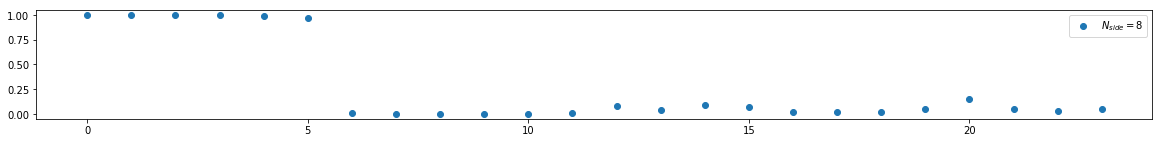

Threshold:  0.631578947368421
Number of neighbours:  64.59375


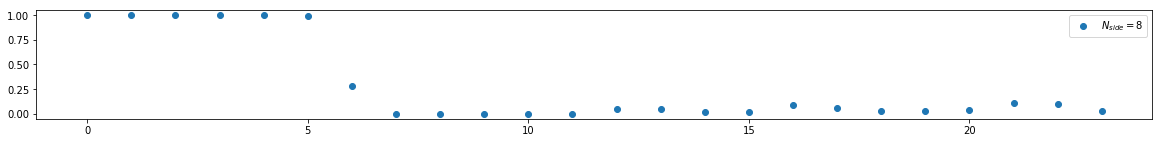

Threshold:  0.6842105263157894
Number of neighbours:  53.489583333333336


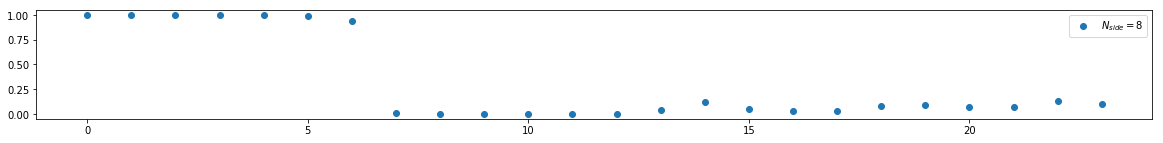

Threshold:  0.7368421052631579
Number of neighbours:  41.59375


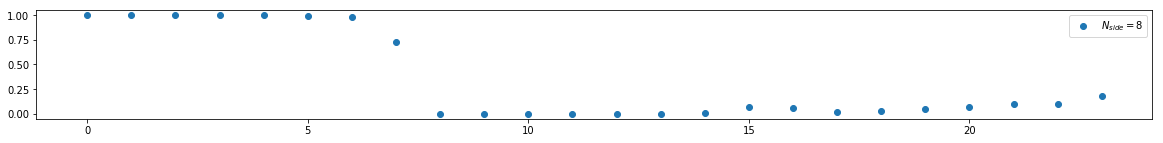

Threshold:  0.7894736842105263
Number of neighbours:  33.927083333333336


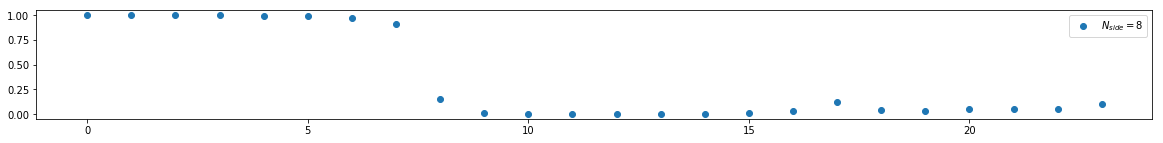

Threshold:  0.8421052631578947
Number of neighbours:  22.90625


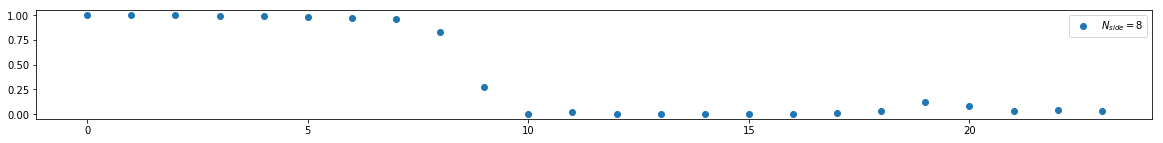

Threshold:  0.894736842105263
Number of neighbours:  15.635416666666666


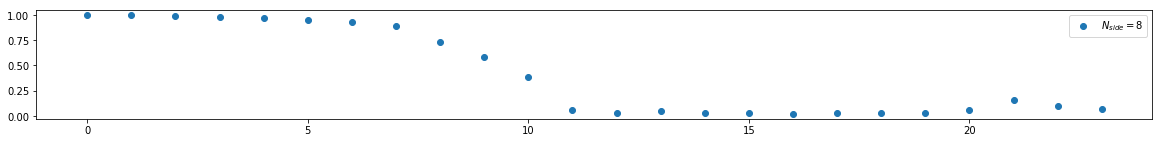

Threshold:  0.9473684210526315
Number of neighbours:  7.25


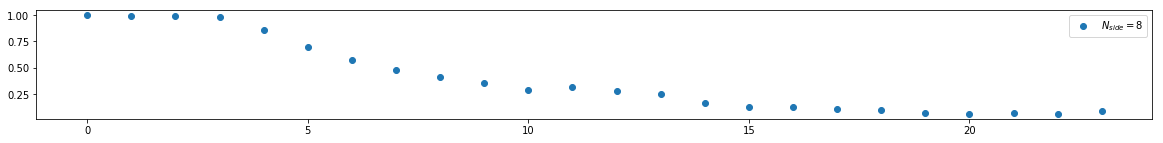

In [29]:
spectral_content = dict()

ks=np.linspace(0, 1, 20)[:-1]

full_graph = utils.full_healpix_geodesic_graph(nside, dtype=np.float64, std="BelkinNyiogi")  # in NEST order
nside = 8
lmax = 3 * nside - 1
n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]

for k in ks:

    # thresholding weights to impose sparsity     
    W = full_graph.W.copy()
    W[W < k] = 0
    graph = pg.graphs.Graph(W)
    print("Threshold: ", k)
    print("Number of neighbours: ", np.mean(np.sum(W>0, axis=1)))
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

    fig2, ax2 = plt.subplots(figsize=(20,2))

    sc = spectral_content[nside]
    sc = sc / sc[0, 0]

    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

    ax2.legend();
    plt.show()

## Let's try with a much smaller std_dev

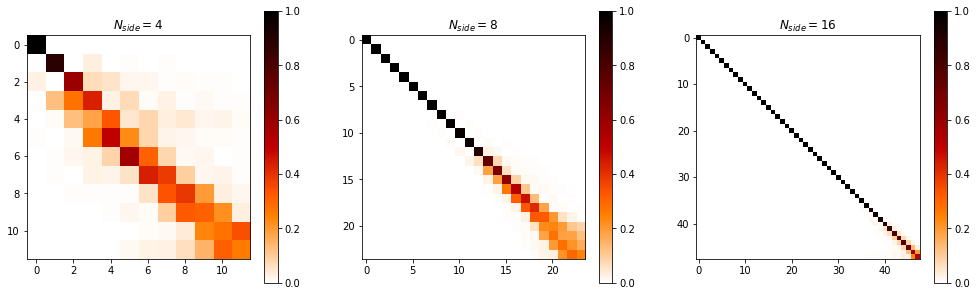

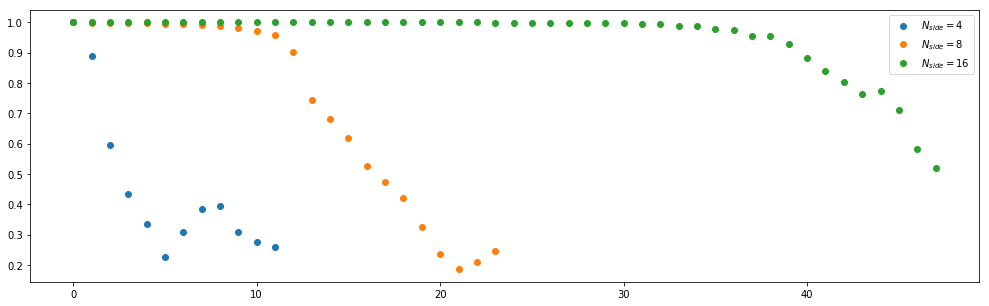

In [12]:
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graph = utils.full_healpix_graph(nside, dtype=np.float64, std=0.01)  # in NEST order
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();

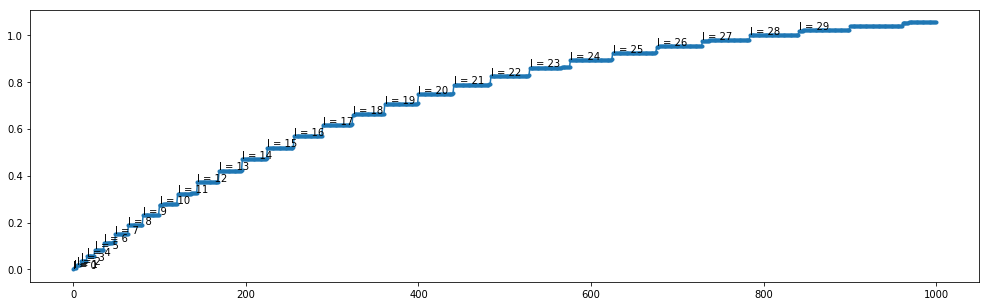

In [19]:
plt.plot(graph.e[:1000], '.-')
idx = 0
for l in range(30):
    plt.text(idx, graph.e[idx] + 0.005, 'l = {}'.format(l))
    idx += 2*l + 1

### Things get so much better! 
For low values of N_side things get worse since we lack the resolution to catch such fast variations of the kernel, but as we get enough resolution things get nicer! The eigenvalues are spaced, the eigenspaces are distinct and alligned with the continuous ones!

### Let's try with a veeery small sigma:

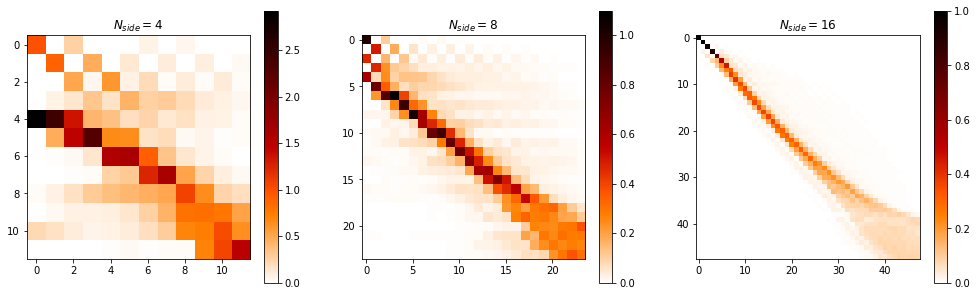

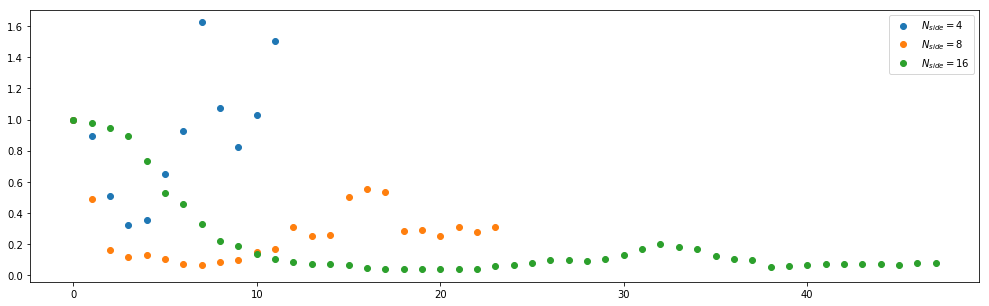

In [24]:
nsides = [4, 8, 16]

spectral_content = dict()

for nside in nsides:

    lmax = 3 * nside - 1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graph = utils.full_healpix_graph(nside, dtype=np.float64, std=0.001)  # in NEST order
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        # alm = hp.sphtfunc.map2alm(eigenvector)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

fig1, axes = plt.subplots(1, len(nsides))
fig2, ax2 = plt.subplots()

for ax, (nside, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    fig1.colorbar(im, ax=ax)
    ax.set_title(rf'$N_{{side}}={nside}$')

    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();

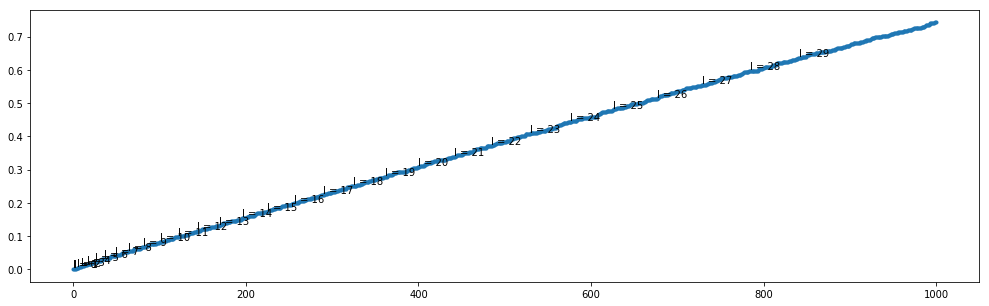

In [25]:
plt.plot(graph.e[:1000], '.-')
idx = 0
for l in range(30):
    plt.text(idx, graph.e[idx] + 0.005, 'l = {}'.format(l))
    idx += 2*l + 1

### Let's analyse the sparsity pattern now

Threshold:  0.0
Number of neighbours:  3071.0


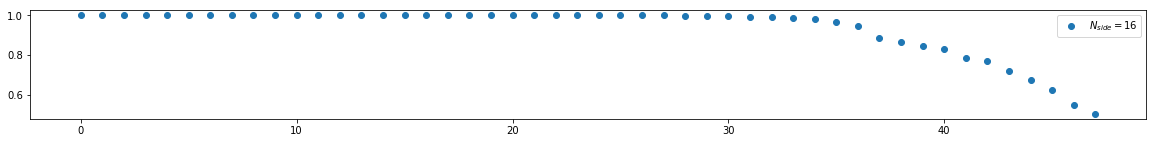

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Threshold:  0.0011111111111111111
Number of neighbours:  51.794270833333336


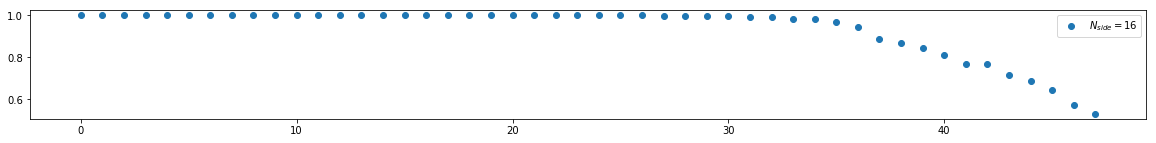

Threshold:  0.0022222222222222222
Number of neighbours:  44.033854166666664


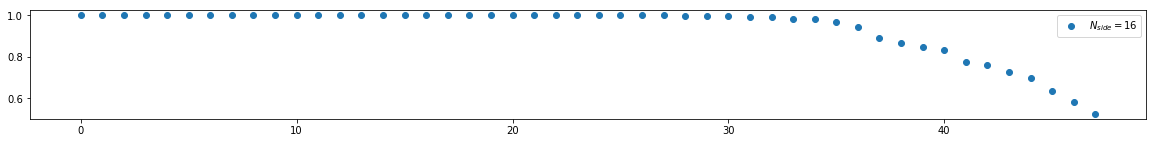

Threshold:  0.003333333333333333
Number of neighbours:  42.075520833333336


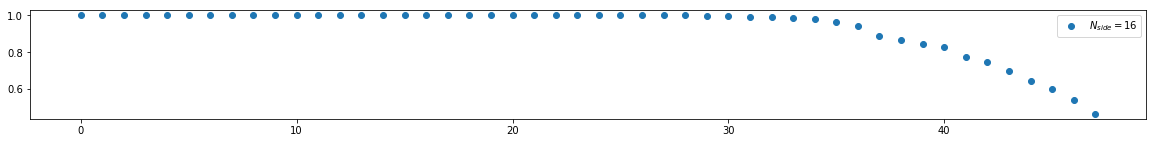

Threshold:  0.0044444444444444444
Number of neighbours:  40.856770833333336


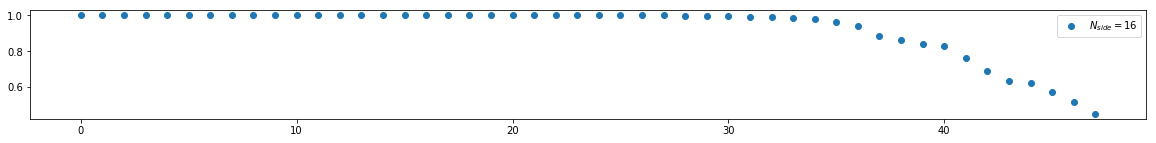

Threshold:  0.005555555555555556
Number of neighbours:  39.533854166666664


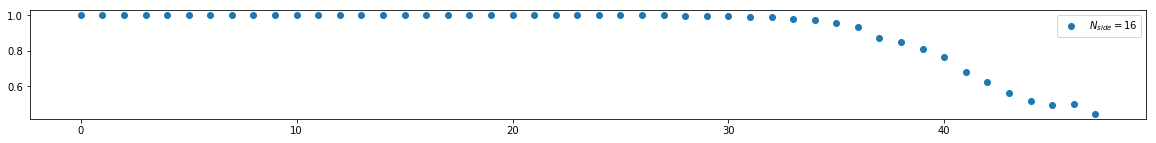

Threshold:  0.006666666666666666
Number of neighbours:  38.309895833333336


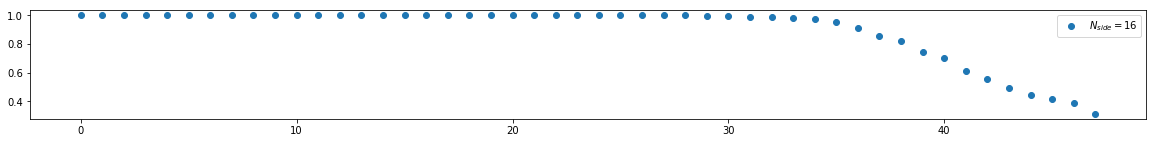

Threshold:  0.0077777777777777776
Number of neighbours:  37.5546875


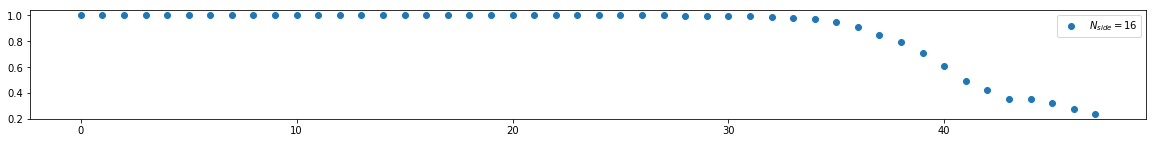

Threshold:  0.008888888888888889
Number of neighbours:  36.3203125


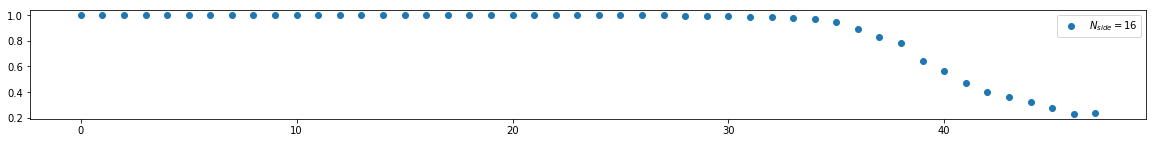

In [39]:
spectral_content = dict()

ks=np.linspace(0, 0.01, 10)[:-1]
nside = 16
full_graph = utils.full_healpix_graph(nside, dtype=np.float64, std=0.01)  # in NEST order

lmax = 3 * nside - 1
n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]

for k in ks:

    # thresholding weights to impose sparsity     
    W = full_graph.W.copy()
    W[W < k] = 0
    graph = pg.graphs.Graph(W)
    print("Threshold: ", k)
    print("Number of neighbours: ", np.mean(np.sum(W>0, axis=1)))
    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = hp.reorder(graph.U[:, i], n2r=True)
        cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

    spectral_content[nside] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
        start = end

    fig2, ax2 = plt.subplots(figsize=(20,2))

    sc = spectral_content[nside]
    sc = sc / sc[0, 0]

    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

    ax2.legend();
    plt.show()

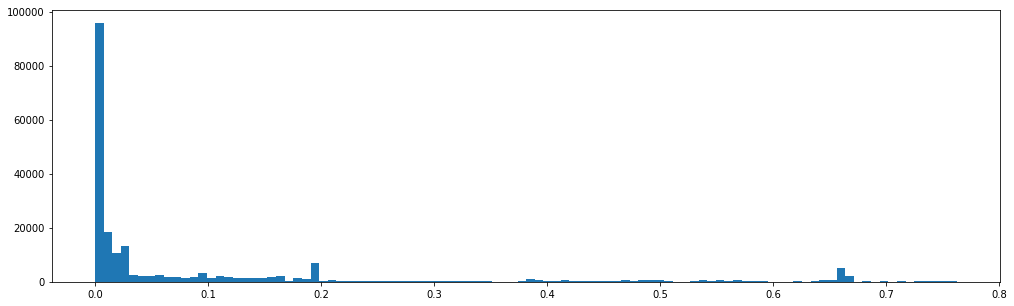

In [70]:
full_graph = utils.full_healpix_graph(nside, dtype=np.float64, std=0.01)  # in NEST order
W = full_graph.W.toarray()
plt.hist(np.ravel(W[W>0.0001]), 100);

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Threshold:  0.01
Number of neighbours:  35.3515625


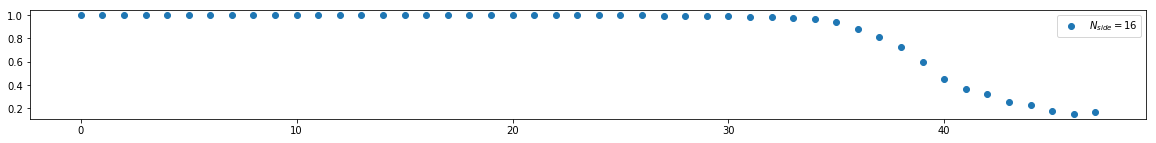

In [63]:
spectral_content = dict()


nside = 16
full_graph = utils.full_healpix_graph(nside, dtype=np.float64, std=0.01)  # in NEST order

lmax = 3 * nside - 1
n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]

k = 0.01

# thresholding weights to impose sparsity     
W = full_graph.W.copy()
W[W < k] = 0
graph = pg.graphs.Graph(W)
print("Threshold: ", k)
print("Number of neighbours: ", np.mean(np.sum(W>0, axis=1)))
graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

cl = np.empty((n_harmonics, lmax+1))
for i in range(n_harmonics):
    eigenvector = hp.reorder(graph.U[:, i], n2r=True)
    cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

spectral_content[nside] = np.empty((lmax+1, lmax+1))
start = 0
for ell in range(lmax+1):
    end = start + (2 * ell + 1)
    spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
    start = end

fig2, ax2 = plt.subplots(figsize=(20,2))

sc = spectral_content[nside]
sc = sc / sc[0, 0]

energy_in = np.diag(sc)
ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();
plt.show()

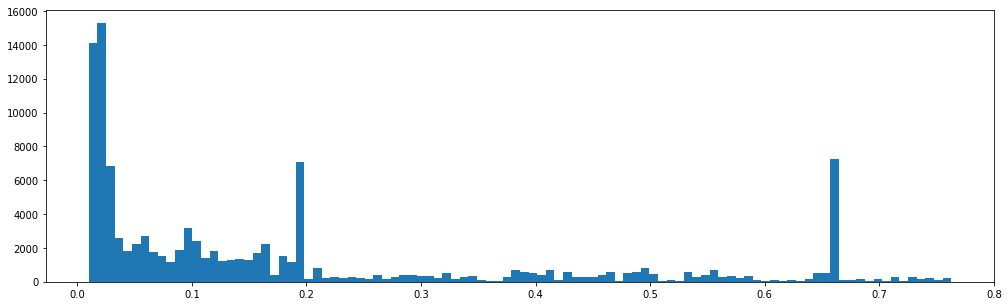

In [80]:
W = graph.W.toarray()
plt.hist(np.ravel(W[W!=0]), 100);

I plot the squared distances as I hope to identify peaks to understand how to set the standard deviation

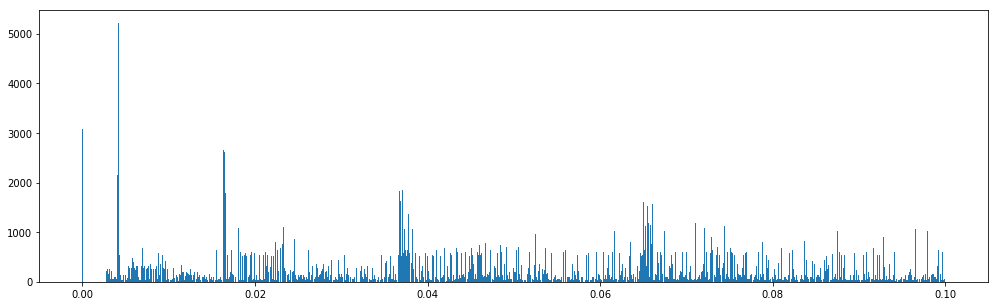

In [82]:
utils.full_healpix_weightmatrix(nside=16, dtype=np.float32, std=0.01, plot=True);

It seems that the first neighbors of a pixel are at a squared distance of less than 0.01; with a standard deviation of $\sigma=0.01$ and by thresholding the weight matrix at $e^{-4\sigma/\sigma}$ I could have a good approximation of the full graph 

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Threshold:  0.01831563888873418
Number of neighbours:  30.4765625


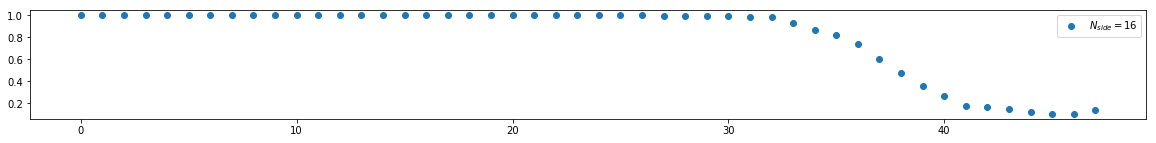

In [84]:
spectral_content = dict()


nside = 16
full_graph = utils.full_healpix_graph(nside, dtype=np.float64, std=0.01)  # in NEST order

lmax = 3 * nside - 1
n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]

k = np.exp(-4)

# thresholding weights to impose sparsity     
W = full_graph.W.copy()
W[W < k] = 0
graph = pg.graphs.Graph(W)
print("Threshold: ", k)
print("Number of neighbours: ", np.mean(np.sum(W>0, axis=1)))
graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

cl = np.empty((n_harmonics, lmax+1))
for i in range(n_harmonics):
    eigenvector = hp.reorder(graph.U[:, i], n2r=True)
    cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

spectral_content[nside] = np.empty((lmax+1, lmax+1))
start = 0
for ell in range(lmax+1):
    end = start + (2 * ell + 1)
    spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
    start = end

fig2, ax2 = plt.subplots(figsize=(20,2))

sc = spectral_content[nside]
sc = sc / sc[0, 0]

energy_in = np.diag(sc)
ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();
plt.show()

### comparison with the full graph:

Threshold:  0.01831563888873418
Number of neighbours:  3071.0


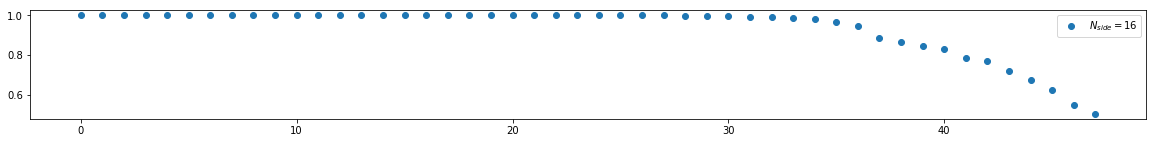

In [85]:
spectral_content = dict()


nside = 16
full_graph = utils.full_healpix_graph(nside, dtype=np.float64, std=0.01)  # in NEST order

lmax = 3 * nside - 1
n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]

# thresholding weights to impose sparsity     
W = full_graph.W.copy()

graph = pg.graphs.Graph(W)
print("Threshold: ", k)
print("Number of neighbours: ", np.mean(np.sum(W>0, axis=1)))
graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

cl = np.empty((n_harmonics, lmax+1))
for i in range(n_harmonics):
    eigenvector = hp.reorder(graph.U[:, i], n2r=True)
    cl[i] = hp.sphtfunc.anafast(eigenvector, lmax=lmax)

spectral_content[nside] = np.empty((lmax+1, lmax+1))
start = 0
for ell in range(lmax+1):
    end = start + (2 * ell + 1)
    spectral_content[nside][ell] = np.sum(cl[start:end,:], axis=0)
    start = end

fig2, ax2 = plt.subplots(figsize=(20,2))

sc = spectral_content[nside]
sc = sc / sc[0, 0]

energy_in = np.diag(sc)
ax2.plot(energy_in, 'o', label=rf'$N_{{side}}={nside}$')

ax2.legend();
plt.show()

## TOP!